In [1]:
%%capture
!pip install transformers trl accelerate torch bitsandbytes peft datasets -qU

In [2]:
%%capture
!pip install flash_attn

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [44]:
import os
import torch
from datasets import Dataset
import pandas as pd
from transformers import (
    AutoModelForCausalLM,
    AutoTokenizer,
    BitsAndBytesConfig,
    TrainingArguments,
    DataCollatorWithPadding
)
from peft import LoraConfig, get_peft_model, prepare_model_for_kbit_training
from trl import SFTTrainer

In [5]:
# Model from Hugging Face hub
base_model = "meta-llama/Llama-2-7b-chat-hf"
# base_model = "mistralai/Mistral-7B-Instruct-v0.2"
# base_model = "mistralai/Mixtral-8x7B-Instruct-v0.1"
#base_model = "meta-llama/Meta-Llama-3-8B-Instruct"

# Fine-tuned model
# new_model = "/content/" + base_model.split("/")[-1]
new_model = '/content/drive/MyDrive/Dartmouth /2024 Spring/Computational Healthcare Project/llama_with_weak_labels/' + base_model.split("/")[-1]

In [7]:
#dataset
df = pd.read_csv("content/train_data.csv")

# Load the weak labels dataset
weak_df = pd.read_csv("content/train_data_weak_labels.csv")

In [8]:
df.shape
weak_df.shape

(10154, 3)

In [9]:
def create_prompt(statement1, statement2):
  system_message = """<s>[INST]You are given a task to find if the given pair of statements are divergent or not. For example, the statement 'Community water fluoridation has been a proven method to improve health for over 70 years.' and 'Excess amounts of fluoride ions in drinking water has negative health effects.' are a pair of divergent statements because the former establishes water fluoridation as a safe method to improve public health whereas the latter discourages the use of flourination as excess flouride ions have detrimental health effects. Here is another example: the statements 'Compared to the flu, the death rate for Covid-19 patients was very high.' and 'Higher mortality of Covid-19 could be due to medical constraints created by the sudden influx of patients over a short period of time.' are not a divergent pair of statements because the former compares the mortality of Covid-19 to the flu whereas the latter discusses the possible reasons for the high mortality rate due to Covid-19 virus. Let's work this out with the statements provided below in a step by step way to be sure we have the right answer. The first statement is the value for the key 'Statement 1:' and the second statement is the value for the key 'Statement 2:' in the dictionary.\nStatement 1: {}\nStatement 2: {}\nYour final answer should only contain the word 'Divergent' or 'Not Divergent'.[/INST]""".format(statement1, statement2)

  # system_message = """You are given a task to find if the given pair of statements are divergent or not. For example, the statement 'Community water fluoridation has been a proven method to improve health for over 70 years.' and 'Excess amounts of fluoride ions in drinking water has negative health effects.' are a pair of divergent statements because the former establishes water fluoridation as a safe method to improve public health whereas the latter discourages the use of flourination as excess flouride ions have detrimental health effects. Here is another example: the statements 'Compared to the flu, the death rate for Covid-19 patients was very high.' and 'Higher mortality of Covid-19 could be due to medical constraints created by the sudden influx of patients over a short period of time.' are not a divergent pair of statements because the former compares the mortality of Covid-19 to the flu whereas the latter discusses the possible reasons for the high mortality rate due to Covid-19 virus. Let's work this out with the statements provided below in a step by step way to be sure we have the right answer. The first statement is the value for the key 'Statement 1:' and the second statement is the value for the key 'Statement 2:' in the dictionary.\nStatement 1: {}\nStatement 2: {}\nYour final answer should only contain the word 'Divergent' or 'Not Divergent'.""".format(statement1, statement2)

  full_prompt = ""
  full_prompt += system_message

  return full_prompt

def create_label(relationship):
  response = f"{relationship}</s>"

  return response



In [19]:
df['instruction_prompt'] = df.apply(lambda row: create_prompt(row['text1'], row['text2']), axis=1)
df['label']  = df.apply(lambda row: create_label(row["divergent_or_not_divergent"]), axis=1)
df['weight'] = 1  # Strong labels have weight 1

# weak_df['instruction_prompt'] = weak_df.apply(lambda row: create_prompt(row['text1'], row['text2'], row["divergent_or_not_divergent"]), axis=1)
weak_df['instruction_prompt'] = weak_df.apply(lambda row: create_prompt(row['text1'], row['text2']), axis=1)
weak_df['label']  = weak_df.apply(lambda row: create_label(row["divergent_or_not_divergent"]), axis=1)
weak_df['weight'] = 0.5  # Weak labels have a lower weight say 0.5

weak_df = weak_df.sample(n=3000, random_state=42)

In [20]:
df.head()

,text1,text2,divergent_or_not_divergent,instruction_prompt,label,weight
0,Formulation of genetically modified food endan...,Genetically modified food is often subject to ...,divergent,<s>[INST]You are given a task to find if the g...,divergent</s>,1
1,Formulation of genetically modified food endan...,Many of the processes employed in genetic modi...,divergent,<s>[INST]You are given a task to find if the g...,divergent</s>,1
2,Tilling is not a hard requirement for farming ...,"Conventional tilling, needed to keep non-GM cr...",divergent,<s>[INST]You are given a task to find if the g...,divergent</s>,1
3,Use of the herbicide glyphosate has dramatical...,Multiple studies linking glyphosate to numerou...,divergent,<s>[INST]You are given a task to find if the g...,divergent</s>,1
4,The recent rise in celiac disease correlates w...,While the study referenced above touches on po...,divergent,<s>[INST]You are given a task to find if the g...,divergent</s>,1


In [21]:
weak_df.head()

,text1,text2,divergent_or_not_divergent,instruction_prompt,label,weight
2986,Healthcare consumers want good health outcomes...,The only healthcare provided by the market is ...,Divergent,<s>[INST]You are given a task to find if the g...,Divergent</s>,0.5
8831,It is necessary to know the extent of economic...,Rather than immediately jumping to an offender...,Not Divergent,<s>[INST]You are given a task to find if the g...,Not Divergent</s>,0.5
9389,Most of these diet products don't have health ...,It's the consumer's responsibility to research...,Divergent,<s>[INST]You are given a task to find if the g...,Divergent</s>,0.5
5660,"If the government requires the courses, they s...",Parents may not have the money to pay for clas...,Not Divergent,<s>[INST]You are given a task to find if the g...,Not Divergent</s>,0.5
367,If the child is a seperate entity to the prega...,Unlike the relationship between a person and a...,Divergent,<s>[INST]You are given a task to find if the g...,Divergent</s>,0.5


In [22]:
df.shape
weak_df.shape

(3000, 6)

In [23]:
# Combine the two datasets
combined_df = pd.concat([df, weak_df], ignore_index=True)

In [24]:
combined_df.shape

(3257, 6)

In [25]:
print(new_model)

/content/drive/MyDrive/Dartmouth /2024 Spring/Computational Healthcare Project/llama_with_weak_labels/Llama-2-7b-chat-hf


In [26]:
tds = Dataset.from_pandas(combined_df[['instruction_prompt', 'label', 'weight']])
tds

Dataset({
    features: ['instruction_prompt', 'label', 'weight'],
    num_rows: 3257
})

In [27]:
quant_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16,
    bnb_4bit_use_double_quant=False,
)

In [28]:
!pip install huggingface_hub

from huggingface_hub import notebook_login

notebook_login()

In [29]:
model = AutoModelForCausalLM.from_pretrained(
    base_model,
    quantization_config=quant_config,
    device_map='auto',
    attn_implementation="flash_attention_2"
)
model.config.use_cache = False
model.config.pretraining_tp = 1

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/614 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/26.8k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/9.98G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/3.50G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/188 [00:00<?, ?B/s]

In [30]:
tokenizer = AutoTokenizer.from_pretrained(base_model, trust_remote_code=True)
tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side = "right"

tokenizer_config.json:   0%|          | 0.00/1.62k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.84M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/414 [00:00<?, ?B/s]

In [31]:
peft_config = LoraConfig(
    lora_alpha=16,
    lora_dropout=0.1,
    r=64,
    bias="none",
        target_modules=[
        "q_proj",
        "k_proj",
        "v_proj",
        "o_proj",
        "gate_proj",
        "up_proj",
        "down_proj",
        "lm_head",
    ],
    task_type="CAUSAL_LM"
)

In [32]:
model = prepare_model_for_kbit_training(model)
model = get_peft_model(model, peft_config)

In [33]:
if torch.cuda.device_count() > 1: # If more than 1 GPU
    print(torch.cuda.device_count())
    model.is_parallelizable = True
    model.model_parallel = True

In [34]:
args = TrainingArguments(
  output_dir = "/content/drive/MyDrive/Dartmouth /2024 Spring/Computational Healthcare Project/llama_with_weak_labels",
  num_train_epochs=10,
  per_device_train_batch_size = 12,
  warmup_steps = 0.03,
  logging_steps=10,
  save_strategy="epoch",
  evaluation_strategy="no",
  learning_rate=2.5e-5,
  bf16=True,
)

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1474: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [37]:
class WeightedSFTTrainer(SFTTrainer):

    def compute_loss(self, model, inputs, return_outputs=False):
        labels = inputs.get("labels")
        weights = inputs.pop("weight")

        # Forward pass
        outputs = model(**inputs)
        logits = outputs.get("logits")

        # Shift logits and labels for next token prediction
        shift_logits = logits[..., :-1, :].contiguous()
        shift_labels = labels[..., 1:].contiguous()

        # Compute the loss
        loss_fct = torch.nn.CrossEntropyLoss(reduction='none')
        loss = loss_fct(shift_logits.view(-1, shift_logits.size(-1)), shift_labels.view(-1))

        # Debugging: Print shapes
        # print(f"shift_logits shape: {shift_logits.shape}")
        # print(f"shift_labels shape: {shift_labels.shape}")
        # print(f"loss shape: {loss.shape}")
        # print(f"weights shape: {weights.shape}")

        # Expand weights to match the flattened loss tensor
        expanded_weights = weights.view(-1, 1).repeat(1, shift_labels.size(1)).view(-1)
        weighted_loss = (loss * expanded_weights).mean()
        # expanded_weights = weights.view(-1, 1).expand(loss.size(0) // weights.size(0), weights.size(0)).contiguous().view(-1)
        # weighted_loss = (loss * expanded_weights).mean()

        return (weighted_loss, outputs) if return_outputs else weighted_loss

    def get_train_dataloader(self):
      train_sampler = self._get_train_sampler()
      return torch.utils.data.DataLoader(
          self.train_dataset,
          batch_size=self.args.train_batch_size,
          sampler=train_sampler,
          collate_fn=self.data_collator,
          drop_last=self.args.dataloader_drop_last,
          num_workers=self.args.dataloader_num_workers,
      )


In [38]:
def calculate_max_length(dataset, tokenizer):
    max_length = 0
    for i in range(len(dataset)):
        prompt = dataset['instruction_prompt'][i]
        tokens = tokenizer(prompt, return_tensors='pt')
        max_length = max(max_length, tokens.input_ids.size(1))
    return max_length

max_length = calculate_max_length(combined_df, tokenizer)
print(f"Maximum length of input prompts: {max_length}")

Maximum length of input prompts: 547


In [39]:
def tokenize_function(examples):

  # Get the instruction_prompt column from the examples
  instruction_prompts = examples['instruction_prompt']
  labels = examples['label']

  # input_tokens = tokenizer(examples['instruction_prompt'], padding='max_length', max_length=max_length_input, truncation=True, return_tensors='pt')
  input_tokens = tokenizer(
        examples['instruction_prompt'],
        padding='max_length',
        truncation=True,
        max_length=512,
        return_tensors='pt'
  )

  # label_tokens = tokenizer(examples['label'], padding='max_length', max_length=max_length_labels, truncation=True, return_tensors='pt')
  label_tokens = tokenizer(
        examples['label'],
        padding='max_length',
        truncation=True,
        max_length=512,
        return_tensors='pt'
  )

  # The labels should align with the input
  labels = label_tokens['input_ids']

  # Replace padding token id by -100 to ignore them in loss computation
  labels[labels == tokenizer.pad_token_id] = -100

  # Create a new dictionary with the desired keys and values
  output = {

      'input_ids': input_tokens['input_ids'],
      'attention_mask': input_tokens['attention_mask'],
      'labels': labels,
      'weight': torch.tensor(examples['weight'], dtype=torch.float32)
  }

  # Debugging: Print shapes to verify batch sizes
  print(f"input_ids shape: {output['input_ids'].shape}")
  print(f"labels shape: {output['labels'].shape}")

  return output

In [40]:
tokenized_datasets = tds.map(tokenize_function, batched=True, remove_columns=['instruction_prompt', 'label'])

Map:   0%|          | 0/3257 [00:00<?, ? examples/s]

input_ids shape: torch.Size([1000, 512])
labels shape: torch.Size([1000, 512])
input_ids shape: torch.Size([1000, 512])
labels shape: torch.Size([1000, 512])
input_ids shape: torch.Size([1000, 512])
labels shape: torch.Size([1000, 512])
input_ids shape: torch.Size([257, 512])
labels shape: torch.Size([257, 512])


In [41]:
tokenized_datasets

Dataset({
    features: ['weight', 'input_ids', 'attention_mask', 'labels'],
    num_rows: 3257
})

In [42]:
# Verify tokenization
print(tokenized_datasets.column_names)
print(tokenized_datasets[1])

['weight', 'input_ids', 'attention_mask', 'labels']
{'weight': 1.0, 'input_ids': [1, 1, 518, 25580, 29962, 3492, 526, 2183, 263, 3414, 304, 1284, 565, 278, 2183, 5101, 310, 9506, 526, 17089, 5362, 470, 451, 29889, 1152, 1342, 29892, 278, 3229, 525, 5261, 6997, 4094, 20501, 272, 333, 362, 756, 1063, 263, 16413, 1158, 304, 11157, 9045, 363, 975, 29871, 29955, 29900, 2440, 6169, 322, 525, 1252, 985, 26999, 310, 20501, 272, 680, 29871, 1080, 297, 13748, 292, 4094, 756, 8178, 9045, 9545, 6169, 526, 263, 5101, 310, 17089, 5362, 9506, 1363, 278, 4642, 10127, 267, 4094, 20501, 272, 333, 362, 408, 263, 9109, 1158, 304, 11157, 970, 9045, 13452, 278, 7480, 2313, 283, 22428, 278, 671, 310, 1652, 473, 3381, 408, 19163, 1652, 283, 2426, 29871, 1080, 505, 1439, 29878, 2073, 284, 9045, 9545, 29889, 2266, 338, 1790, 1342, 29901, 278, 9506, 525, 6843, 1965, 304, 278, 20501, 29892, 278, 4892, 6554, 363, 25669, 333, 29899, 29896, 29929, 22069, 471, 1407, 1880, 6169, 322, 525, 16382, 261, 5758, 2877, 310, 

In [45]:
class DataCollatorForWeightedLanguageModeling(DataCollatorWithPadding):
    def __call__(self, features):
        # print("Features before collating:", features)  # Debug print
        weights = torch.tensor([feature['weight'] for feature in features], dtype=torch.float32)
        for feature in features:
            feature.pop('weight')
        batch = super().__call__(features)
        batch['weight'] = weights
        # print("Batch after collating:", batch)  # Debug print
        return batch


In [46]:
data_collator = DataCollatorForWeightedLanguageModeling(tokenizer)

In [47]:
trainer = WeightedSFTTrainer(
    model=model,
    train_dataset=tokenized_datasets,
    peft_config=peft_config,
    dataset_text_field="instruction_prompt",
    max_seq_length=None,
    tokenizer=tokenizer,
    args=args,
    packing=False,
    data_collator=data_collator
)

/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:246: UserWarning: You didn't pass a `max_seq_length` argument to the SFTTrainer, this will default to 1024
  warnings.warn(


In [49]:
trainer.train()

Step,Training Loss
10,0.029500
20,0.022600
30,0.016100
40,0.009100
50,0.006200
60,0.005500
70,0.004200
80,0.003900
90,0.004200
100,0.003800


/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:180: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:464: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.4 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:180: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers foun

TrainOutput(global_step=2720, training_loss=0.0039038122282363474, metrics={'train_runtime': 8178.9888, 'train_samples_per_second': 3.982, 'train_steps_per_second': 0.333, 'total_flos': 6.780774160269312e+17, 'train_loss': 0.0039038122282363474, 'epoch': 10.0})

In [50]:
trainer.save_model(new_model)

/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:180: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")


In [51]:
merged_model = model.merge_and_unload()

/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/bnb.py:325: UserWarning: Merge lora module to 4-bit linear may get different generations due to rounding errors.
  warnings.warn(


In [52]:
def generate_response(prompt, model):
  encoded_input = tokenizer(prompt,  return_tensors="pt", add_special_tokens=True)
  model_inputs = encoded_input.to('cuda')

  generated_ids = model.generate(**model_inputs,
                                 do_sample=True,
                                 pad_token_id=tokenizer.eos_token_id)

  decoded_output = tokenizer.batch_decode(generated_ids)

  return decoded_output[0]

In [53]:
test_df = pd.read_csv("content/test_data.csv")

In [54]:
zero_shot = []
for i in range(len(zero_shot), len(test_df)):
  prompt = """[INST]You are given a task to find if the given pair of statements are divergent or not. For example, the statement 'Community water fluoridation has been a proven method to improve health for over 70 years.' and 'Excess amounts of fluoride ions in drinking water has negative health effects.' are a pair of divergent statements because the former establishes water fluoridation as a safe method to improve public health whereas the latter discourages the use of flourination as excess flouride ions have detrimental health effects. Here is another example: the statements 'Compared to the flu, the death rate for Covid-19 patients was very high.' and 'Higher mortality of Covid-19 could be due to medical constraints created by the sudden influx of patients over a short period of time.' are not a divergent pair of statements because the former compares the mortality of Covid-19 to the flu whereas the latter discusses the possible reasons for the high mortality rate due to Covid-19 virus. Let's work this out with the statements provided below in a step by step way to be sure we have the right answer. The first statement is the value for the key 'Statement 1:' and the second statement is the value for the key 'Statement 2:' in the dictionary.\nStatement 1: {}\nStatement 2: {}\nYour final answer should only contain the word 'Divergent' or 'Not Divergent'.[/INST]""".format(test_df.iloc[i]['text1'], test_df.iloc[i]['text2'])
  zero_shot.append(generate_response(prompt, merged_model))
  print("{"+str(i)+": "+zero_shot[i]+"}")

test_df['llama_output'] = zero_shot
csv_data = test_df.to_csv("/content/drive/MyDrive/Dartmouth /2024 Spring/Computational Healthcare Project/test_data with llama with weak labels cot response.csv", index = False)
csv_data = test_df.to_csv("/content/drive/MyDrive/Dartmouth /2024 Spring/Computational Healthcare Project/test_data with llama with weak labels cot response backup.csv", index = False)

`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`.
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:464: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.4 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
The input hidden states seems to be silently casted in float32, this might be related to the fact you have upcasted embedding or layer norm layers in float32. We will cast back the input in torch.float16.
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:91: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


{0: <s> [INST]You are given a task to find if the given pair of statements are divergent or not. For example, the statement 'Community water fluoridation has been a proven method to improve health for over 70 years.' and 'Excess amounts of fluoride ions in drinking water has negative health effects.' are a pair of divergent statements because the former establishes water fluoridation as a safe method to improve public health whereas the latter discourages the use of flourination as excess flouride ions have detrimental health effects. Here is another example: the statements 'Compared to the flu, the death rate for Covid-19 patients was very high.' and 'Higher mortality of Covid-19 could be due to medical constraints created by the sudden influx of patients over a short period of time.' are not a divergent pair of statements because the former compares the mortality of Covid-19 to the flu whereas the latter discusses the possible reasons for the high mortality rate due to Covid-19 virus

In [2]:
import pandas as pd

C:\Users\kisho\AppData\Local\Temp\ipykernel_30712\4080736814.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
test_values_df = pd.read_csv("./test_data with llama with weak labels cot response.csv")

In [3]:
test_values_df['refined'] = test_values_df['llama_output'].str[-25:]

In [4]:
test_values_df.head()

,text1,text2,divergent or not divergent,llama_output,refined
0,The state should abide by the precautionary pr...,Genetically modified crops can only be grown i...,divergent,<s> [INST]You are given a task to find if the ...,er is: Not Divergent.</s>
1,While many agricultural practices may be seen ...,Many of the processes employed in genetic modi...,divergent,<s> [INST]You are given a task to find if the ...,t.\n\nAnswer: Divergent</s>
2,Genetically modified crops can be harmful to t...,"Intensive agriculture as a whole, not specific...",divergent,<s> [INST]You are given a task to find if the ...,"nswer is ""Divergent.""</s>"
3,Genetically modified crops can be harmful to t...,Genetic modification can be used to prevent ce...,divergent,<s> [INST]You are given a task to find if the ...,t.\n\nAnswer: Divergent</s>
4,Genetically modified crops can be harmful to t...,GM crops are often modified in ways that can m...,divergent,<s> [INST]You are given a task to find if the ...,answer is: Divergent.</s>


In [5]:
final_value = [""]*len(test_values_df)
for i in range(len(test_values_df)):
  temp = test_values_df.iloc[i]['refined']
  if "Not Divergent" in temp:
    final_value[i] = "not divergent"
  elif "Divergent" in temp:
    final_value[i] = "divergent"

In [6]:
print(final_value)

['not divergent', 'divergent', 'divergent', 'divergent', 'divergent', 'divergent', 'divergent', 'divergent', 'not divergent', 'divergent', 'not divergent', 'not divergent', '', 'divergent', 'not divergent', 'divergent', 'divergent', '', 'divergent', '', 'divergent', '', '', '', 'divergent', 'divergent', 'divergent', 'not divergent', 'divergent', 'divergent', '', '', '', 'divergent', '', 'divergent', '', 'divergent', '', 'divergent', 'divergent', 'not divergent', '', 'divergent', 'divergent', 'not divergent', 'divergent', '', 'divergent', 'divergent', '', 'divergent', '', 'divergent', 'divergent', '', '', '', '', '', 'divergent', 'divergent', 'divergent', '', 'divergent', 'divergent', '', 'divergent', '', 'divergent', 'not divergent', 'not divergent', 'divergent', 'divergent', 'divergent', 'divergent', '', 'not divergent', 'not divergent', '', 'divergent', '', 'divergent', 'divergent', 'divergent', 'not divergent', '', '', '', '', 'divergent', 'divergent', '', '', '', 'not divergent', '

In [7]:
test_values_df['final_val'] = final_value

In [9]:
csv_data = test_values_df.to_csv("./test_data with llama with weak labels cot response refined.csv", index = False)

In [3]:
test_values_df = pd.read_csv("./test_data with llama with weak labels cot response refined.csv")

In [4]:
from sklearn.metrics import classification_report
print(classification_report(list(test_values_df['divergent or not divergent']), list(test_values_df['final_val'])))

               precision    recall  f1-score   support

    divergent       0.59      0.80      0.67       138
not divergent       0.48      0.25      0.33       104

     accuracy                           0.56       242
    macro avg       0.53      0.52      0.50       242
 weighted avg       0.54      0.56      0.53       242



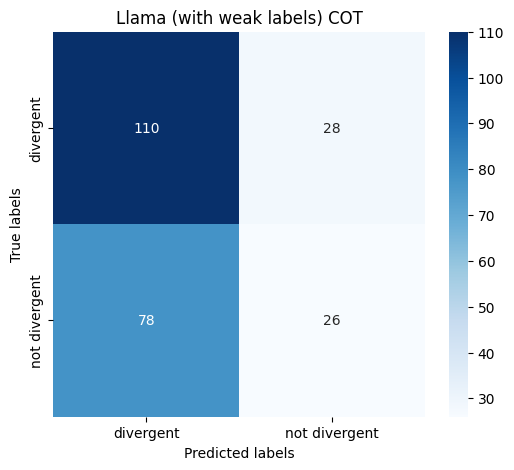

In [6]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns
y_test = test_values_df['divergent or not divergent']
y_pred = test_values_df['final_val']
cm = confusion_matrix(y_test, y_pred, labels=['divergent', 'not divergent'])

plt.figure(figsize=(6, 5))
ax = sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=True, 
                 xticklabels=['divergent', 'not divergent'], yticklabels=['divergent', 'not divergent'])
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
plt.title('Llama (with weak labels) COT')
plt.show()